parallel

In [1]:
using Distributed
using SharedArrays
using Plots

In [2]:
addprocs(3)
@everywhere using Kinetic

In [3]:
procs()

4-element Array{Int64,1}:
 1
 2
 3
 4

In [5]:
ks = SolverSet("sod.txt");

case = sod
space = 1d1f1v
flux = kfvs
collision = bgk
nSpecies = 1
interpOrder = 1
limiter = vanleer
cfl = 0.5
maxTime = 0.2
x0 = 0.0
x1 = 1.0
nx = 1000
pMeshType = uniform
nxg = 0
umin = -5.0
umax = 5.0
nu = 48
vMeshType = rectangle
nug = 0
knudsen = 0.001
mach = 0.0
prandtl = 1.0
inK = 0.0
omega = 0.81
alphaRef = 1.0
omegaRef = 0.5



In [6]:
wp = SharedArray{Float64}((ks.pSpace.nx, 3), init=A->(A=zeros(ks.pSpace.nx, 3)))

for i in 1:ks.pSpace.nx
    if i <= ks.pSpace.nx ÷ 2
        wp[i,:] .= ks.ib.wL
    else
        wp[i,:] .= ks.ib.wR
    end
end     
        
fwp = SharedArray{Float64}((ks.pSpace.nx+1, 3), init=A->(A=zeros(ks.pSpace.nx+1, 3)));

In [7]:
dt = ks.pSpace.dx[1] / (ks.vSpace.u1 + sound_speed(ks.ib.primL, ks.gas.γ))
nt = floor(ks.set.maxTime / dt) |> Int

1244

In [8]:
@time for iter = 1:nt
    @sync @distributed for i in 2:ks.pSpace.nx
        flux = @view fwp[i,:]
        flux_gks!(
            flux,
            wp[i-1,:],
            wp[i,:],
            ks.gas.γ,
            ks.gas.K,
            ks.gas.μᵣ,
            ks.gas.ω,
            dt,
            ks.pSpace.dx[1],
        )
    end
    
    @sync @distributed for i in 2:ks.pSpace.nx-1
        for j in 1:3
            wp[i,j] += (fwp[i,j] - fwp[i+1,j]) / ks.pSpace.dx[i]
        end
    end
end

  8.732770 seconds (2.28 M allocations: 102.924 MiB, 0.27% gc time)


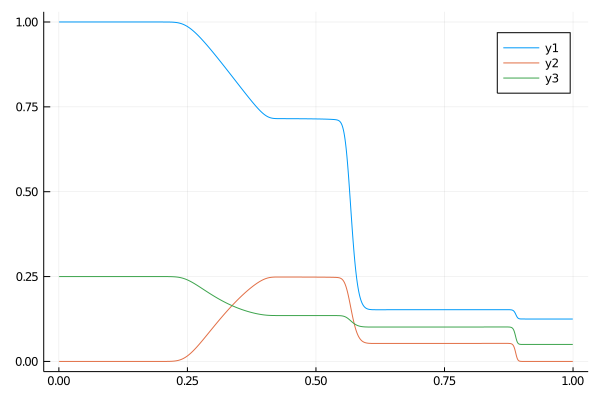

In [28]:
plot(ks.pSpace.x, wp)

serial

In [9]:
w = zeros(ks.pSpace.nx, 3)
for i in 1:ks.pSpace.nx
    if i <= ks.pSpace.nx ÷ 2
        w[i,:] .= ks.ib.wL
    else
        w[i,:] .= ks.ib.wR
    end
end     
        
fw = zeros(ks.pSpace.nx+1, 3);

In [12]:
@time for iter = 1:nt
    for i in 2:ks.pSpace.nx
        flux = @view fw[i,:]
        flux_gks!(
            flux,
            w[i-1,:],
            w[i,:],
            ks.gas.γ,
            ks.gas.K,
            ks.gas.μᵣ,
            ks.gas.ω,
            dt,
            ks.pSpace.dx[1],
        )
    end
    
    for i in 2:ks.pSpace.nx-1
        for j in 1:3
            w[i,j] += (fw[i,j] - fw[i+1,j]) / ks.pSpace.dx[i]
        end
    end
end

 10.279292 seconds (209.82 M allocations: 15.515 GiB, 15.67% gc time)


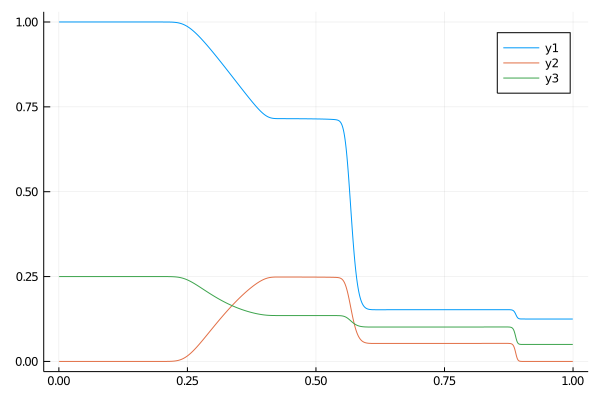

In [31]:
plot(ks.pSpace.x, w)

The computational speed does seem to be improved by 50%.